In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [4]:
plt.rcParams['figure.figsize'] = (15, 8)

## Loading initial datasets and filtering

In [ ]:
results = pd.read_csv('data/ecotox/results.txt',sep='\|', engine='python')
results.head()

In [ ]:
test = pd.read_csv('data/ecotox/tests.txt',sep='\|', engine='python')
test.head()

In [ ]:
species = pd.read_csv('data/ecotox/validation/species.txt',sep='\|', engine='python')
species.head()

In [ ]:
results.to_pickle("data/results.pkl")
test.to_pickle("data/test.pkl")
species.to_pickle("data/species.pkl")

In [39]:
#results = pd.read_pickle("data/results.pkl")
#test = pd.read_pickle("data/test.pkl")
species = pd.read_pickle("data/species.pkl")

In [40]:
species.head()

,species_number,common_name,latin_name,kingdom,phylum_division,subphylum_div,superclass,class,tax_order,family,genus,species,subspecies,variety,ecotox_group
0,1,Fathead Minnow,Pimephales promelas,Animalia,Chordata,Vertebrata,Osteichthyes,Actinopterygii,Cypriniformes,Cyprinidae,Pimephales,promelas,NaN,NaN,"Fish,Standard Test Species"
1,2,Bluegill,Lepomis macrochirus,Animalia,Chordata,Vertebrata,Osteichthyes,Actinopterygii,Perciformes,Centrarchidae,Lepomis,macrochirus,NaN,NaN,"Fish,Standard Test Species"
2,3,Brook Trout,Salvelinus fontinalis,Animalia,Chordata,Vertebrata,Osteichthyes,Actinopterygii,Salmoniformes,Salmonidae,Salvelinus,fontinalis,NaN,NaN,"Fish,Standard Test Species"
3,4,Rainbow Trout,Oncorhynchus mykiss,Animalia,Chordata,Vertebrata,Osteichthyes,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus,mykiss,NaN,NaN,"Fish,Standard Test Species,U.S. Exotic/Nuisanc..."
4,5,Water Flea,Daphnia magna,Animalia,Arthropoda,Crustacea,NaN,Branchiopoda,Diplostraca,Daphniidae,Daphnia,magna,NaN,NaN,"Crustaceans,Standard Test Species"


**Prefilter**
Considering only:
- Endpoint LC50 or EC50 (Mortality at 50%)
- No embrions (Code EM)
- Group Fish

Considering all the endpoints containing LC50 or EC50: there are **different codes identify the same endpoints**

In [109]:
results[results.endpoint.str.contains("LC50")].endpoint.unique()

array(['LC50', 'LC50*', 'LC50/', 'LC50*/'], dtype=object)

In [110]:
results[results.endpoint.str.contains("EC50")].endpoint.unique()

array(['EC50', 'EC50/', 'EC50*', 'EC50*/'], dtype=object)

In [111]:
# Retaining only LC50 or EC50
res_50 = results[(results.endpoint.str.contains("LC50")) | (results.endpoint.str.contains("EC50"))]

Considering the possible effects connected to LC50. We need to filter on **Mortality Group**

In [112]:
res_50.effect.unique()

array(['ITX', 'MOR', 'BEH', 'GRO', 'REP', 'MLT', 'PHY', 'POP', 'BCM',
       'DVP', '~MOR', 'HIS', 'BEH/', 'REP/', 'GEN', '~ITX', 'ENZ', '~DVP',
       'MOR/', 'FDB', 'MPH', 'AVO', '~DVP/', 'INJ', 'HRM', 'CEL', '~REP/',
       'ITX/', 'PRS', 'GRO/', 'POP/', 'PHY/', '~FDB', '~MOR/', '~PHY',
       '~GRO', '~REP', 'IMM', '~BCM', 'NER', 'ENZ/', 'BCM/', 'ACC',
       'FDB/', '~GEN', '~POP', '~MLT', 'DVP/', '~ITX/', '~ACC', '~BEH'],
      dtype=object)

*Note*: ~MOR is **retarted mortality**. MOR/ should be the same as MOR (?)

In [113]:
# Only the ones inside mortality group
res_50_mor = res_50[res_50.effect.str.contains("MOR")]

Look at the possible measurement inside the Mortality Group. **We take them all for now: we may filter only for mortality measurement?**

In [114]:
res_50_mor.measurement.unique()

array(['MORT', 'MORT/', 'SURV', 'TKNO', 'HTCH', 'SURV/', 'SVVS', 'LBCN',
       'HTCH/', 'LFSP', 'GMOR/', 'GMOR', 'LIFE', 'EBCN', 'MDTH', 'LIFE/'],
      dtype=object)

Retaining only **Fish not embrion**

In [115]:
# No embrions in the test
test_no_EM = test[test.organism_lifestage != "EM"]

In [116]:
# No Fish
species = species[~species.ecotox_group.isnull()]
species_fish = species[species.ecotox_group.str.contains("Fish")]

# Merge
test_fish_only = test.merge(species_fish, on="species_number")

Combining **all together**

In [117]:
results_final = res_50_mor.merge(test_fish_only, on = "test_id")

In [118]:
results_final.index.size

64746

In [121]:
results_final.to_pickle("data/results_final.pkl")

In [6]:
results_final.columns.values

array(['result_id', 'test_id', 'sample_size_mean_op', 'sample_size_mean',
       'sample_size_min_op', 'sample_size_min', 'sample_size_max_op',
       'sample_size_max', 'sample_size_unit', 'sample_size_comments',
       'obs_duration_mean_op', 'obs_duration_mean', 'obs_duration_min_op',
       'obs_duration_min', 'obs_duration_max_op', 'obs_duration_max',
       'obs_duration_unit', 'obs_duration_comments', 'endpoint',
       'endpoint_comments', 'trend', 'effect', 'effect_comments',
       'measurement', 'measurement_comments', 'response_site',
       'response_site_comments', 'effect_pct_mean_op', 'effect_pct_mean',
       'effect_pct_min_op', 'effect_pct_min', 'effect_pct_max_op',
       'effect_pct_max', 'effect_pct_comments', 'conc1_type', 'ion1',
       'conc1_mean_op', 'conc1_mean', 'conc1_min_op', 'conc1_min',
       'conc1_max_op', 'conc1_max', 'conc1_unit', 'conc1_comments',
       'conc2_type', 'ion2', 'conc2_mean_op', 'conc2_mean',
       'conc2_min_op', 'conc2_min', 'conc

## Looking for null values, outliers and strange units in the new datasets

### CAS : Foreign key to CHEMICALS

In [3]:
results_final= pd.read_pickle("data/results_final.pkl")

In [4]:
# It's an index -> shouldn't be null values
sum(results_final['test_cas'].isnull())

0

No sense talking about outliers (possible with ECOTOX_GROUP when we will talk about the CAS characteristics)

**Defining a function to count the NaN and the possible outputs for one of the interested big features**

In [11]:
def null_output_counts(feature, dataframe):
    
    # Find columns that start with the interesting feature
    cols = list(dataframe.columns)
    features_interested = [i for i in cols if i.startswith(feature)]
    df_nan  = pd.DataFrame (index = features_interested, columns = ['null_values_inc_NC_NR%', '#outputs'])
    
    #Count total NaN + NR + NC
    for i in features_interested:
        df_nan['null_values_inc_NC_NR%'][i] = (sum(dataframe[i].isnull()) + len(dataframe[dataframe[i] == "NR"]) + len(dataframe[dataframe[i] =="NC"]))/len(dataframe)*100
        df_nan['#outputs'][i] = len(dataframe[i].unique())
    return df_nan, features_interested

### ORGANISMS

In [7]:
# Apply defined function to organism
df_org_nan, org_list = null_output_counts("organism", results_final)
df_org_nan

,null_values_inc_NC_NR%,#outputs
organism_final_wt_mean_op,100,1
organism_final_wt_mean,99.9707,6
organism_final_wt_min_op,100,1
organism_final_wt_min,99.9722,8
organism_final_wt_max_op,100,1
organism_final_wt_max,99.9722,8
organism_final_wt_unit,99.966,4
organism_final_wt_comments,100,1
organism_habitat,0,1
organism_source,89.7986,9


In [9]:
df_org_nan[df_org_nan['null_values_inc_NC_NR%']<=65]

,null_values_inc_NC_NR%,#outputs
organism_habitat,0,1
organism_lifestage,63.5653,46
organism_characteristics,31.8151,6521


In [30]:
columns_final = ["organism_lifestage", "organism_characteristics"]

*Organism_habitat* has only one output, so we condiser it irrelevant for the analysis.

**Usable features**: *organism_lifestage* *organism_characteristics*(?)

*organism_characteristics*

In [13]:
results_final.organism_characteristics.value_counts().head(10)

NR       20574
1G         894
0.8G       750
N.R.       654
0.5 G      629
0.7G       560
0.6G       489
1.1 G      483
0.9G       475
1 G        461
Name: organism_characteristics, dtype: int64

*Organism_characteristics* has too many outputs, so we condiser it irrelevant for the analysis.

*organism_lifestage*

In [14]:
results_final.organism_lifestage.value_counts(dropna=False).head(20)

NR    38329
JV     6412
FI     3944
LV     2899
NC     2827
FY     2584
AD     2003
EG     1093
EM      959
SU      542
SF      501
YY      476
YO      321
AL      265
MX      257
YE      196
EY      154
LR       99
PA       96
UY       92
Name: organism_lifestage, dtype: int64

A lot of NR and NC, but once dropped/imputed (I don't see how imputing a categorical like this one) seems a useful feature.
<br>
We could also creates other dataframe has we did in the previous project.

Let's have a look at the other variable, to see how they are distributed

In [16]:
organism_lifestage_unit_counts=results_final[(results_final.organism_lifestage!='NR')&(results_final.organism_lifestage!='NC')]\
                                .organism_lifestage.value_counts()

c:\users\mvice\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  """Entry point for launching an IPython kernel.


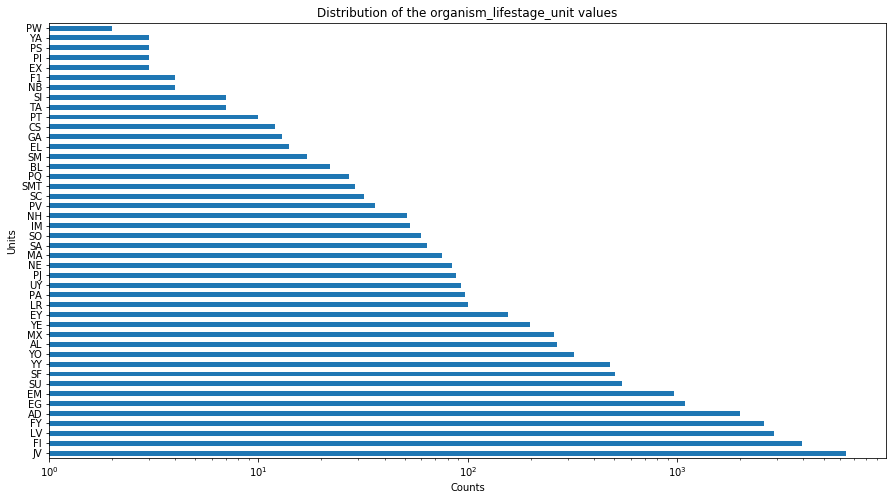

In [27]:
organism_lifestage_unit_counts.plot('barh', log=True)
plt.title("Distribution of the organism_lifestage_unit values")
plt.xlabel("Counts")
plt.ylabel("Units");

### EXPOSURES\OBSERVATION\STUDY DURATION

Considering all the columns considering a "duration" inside

In [127]:
results_final.columns[results_final.columns.str.contains("duration")]

Index(['obs_duration_mean_op', 'obs_duration_mean', 'obs_duration_min_op',
       'obs_duration_min', 'obs_duration_max_op', 'obs_duration_max',
       'obs_duration_unit', 'obs_duration_comments', 'study_duration_mean_op',
       'study_duration_mean', 'study_duration_min_op', 'study_duration_min',
       'study_duration_max_op', 'study_duration_max', 'study_duration_unit',
       'study_duration_comments', 'exposure_duration_mean_op',
       'exposure_duration_mean', 'exposure_duration_min_op',
       'exposure_duration_min', 'exposure_duration_max_op',
       'exposure_duration_max', 'exposure_duration_unit',
       'exposure_duration_comments'],
      dtype='object')

We have **exposure, observation or study duration**.
#### Starting by exposure

In [136]:
# Computing dataframe for exposure
df_exp_nan, exp_list = null_output_counts("exposure", results_final)
df_exp_nan

,null_values_inc_NC_NR%,#outputs
exposure_duration_mean_op,99.8224,5
exposure_duration_mean,85.3705,74
exposure_duration_min_op,99.9645,3
exposure_duration_min,99.9537,6
exposure_duration_max_op,99.9645,3
exposure_duration_max,99.9537,6
exposure_duration_unit,85.3242,10
exposure_duration_comments,99.9521,3
exposure_type,8.2229,21
exposure_type_comments,99.7359,2


**85%** of the exposure_duration_mean (most interesting feature here are **missing**). **exposure_type** could contain useful info.  
Moving on considering duration_unit, mean and exposure_type

In [123]:
exp_intrs = ["exposure_duration_unit", "exposure_duration_mean", "exposure_type"]
df_exp = results_final[exp_intrs]

Counting the number of each value:

In [124]:
exposure_duration_unit_counts = df_exp.exposure_duration_unit.value_counts(dropna=False)
exposure_duration_unit_counts

NC     55243
h       8882
d        520
mi        43
hpf       42
dph        8
dpf        5
ht         1
wk         1
NaN        1
Name: exposure_duration_unit, dtype: int64

In [160]:
# Removing NaN for plot
exposure_duration_unit_counts = df_exp.exposure_duration_unit.value_counts()

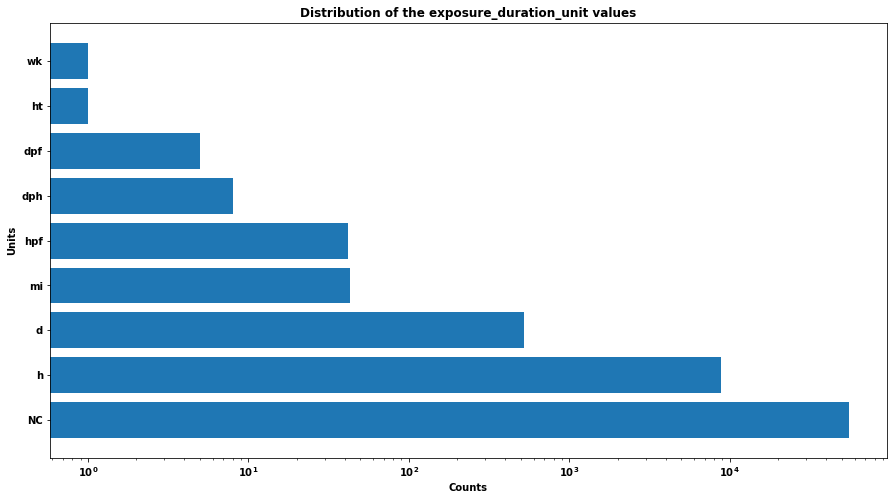

In [167]:
plt.barh(exposure_duration_unit_counts.index, exposure_duration_unit_counts.values, log=True)
plt.title("Distribution of the exposure_duration_unit values")
plt.xlabel("Counts")
plt.ylabel("Units");

**_Note_: log scale used**

**55243 NC + 14 NaN**.  
Reflecting in exposure_duration_mean:

In [128]:
df_exp[df_exp.exposure_duration_unit == "NC"].exposure_duration_mean.value_counts(dropna=False)

NC    55243
Name: exposure_duration_mean, dtype: int64

Same number: **all NC** from one side have the same NC in duration_mean

Duration unit meanings:
- h/d/wk/mi/s/mo/yr = hour/day/weeks/minute/seconds/month/years
- ht: until hatch
- dph: days post hatch
- hpf: hours post fertilization

Full list in **data/DataCodes.pdf (Appendix I)**

Considering the top cases for strange units:

In [130]:
df_exp[df_exp.exposure_duration_unit == "hpf"].exposure_duration_mean.value_counts(dropna=False)

96     31
144     7
120     3
NR      1
Name: exposure_duration_mean, dtype: int64

In [131]:
df_exp[df_exp.exposure_duration_unit == "dph"].exposure_duration_mean.value_counts(dropna=False)

28    8
Name: exposure_duration_mean, dtype: int64

In [132]:
df_exp[df_exp.exposure_duration_unit == "ht"].exposure_duration_mean.value_counts(dropna=False)

NaN    1
Name: exposure_duration_mean, dtype: int64

The strange values could be converted easily. Hovewer, the problem is the **high value of missing numbers**  
Analyzing exposure_type:

In [139]:
df_exp.exposure_type.unique()

array(['S', 'F', 'NR', 'R', 'AQUA - NR', 'YK', 'P', 'S/', 'E', 'IP', 'R/',
       'SP', 'NR/', 'OR', 'F/', 'P/', 'O', 'IV', 'FD', 'SC', 'IJ'],
      dtype=object)

Seems good as categorical. Counting:

In [140]:
exposure_type_counts = df_exp.exposure_type.value_counts(dropna=False)
exposure_type_counts

S            38337
F            13376
R             6790
NR            5324
AQUA - NR      517
P              131
S/              70
R/              69
E               48
O               19
NR/             14
IP              13
F/              12
YK               7
P/               6
OR               4
FD               3
IV               3
SP               1
IJ               1
SC               1
Name: exposure_type, dtype: int64

About 5000 missing values: can be used after **imputing them**  
*Idea*: using AQUA for all of them (?)

In [31]:
columns_final.append("exposure_type")

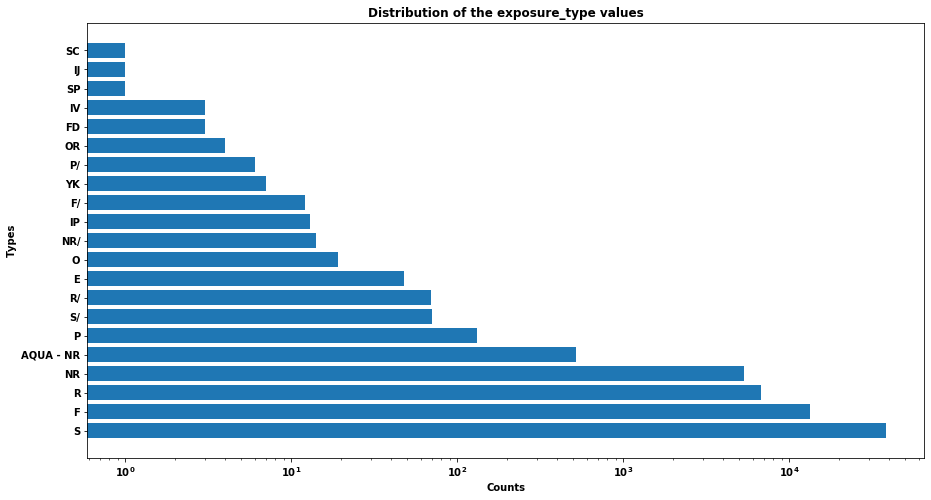

In [168]:
plt.barh(exposure_type_counts.index, exposure_type_counts.values, log=True)
plt.title("Distribution of the exposure_type values")
plt.xlabel("Counts")
plt.ylabel("Types");

**_Note_: log scale used**

#### Observation duration

In [135]:
df_obs_nan, exp_list = null_output_counts("obs", results_final)
df_obs_nan

,null_values_inc_NC_NR%,#outputs
obs_duration_mean_op,99.4424,5
obs_duration_mean,1.85649,325
obs_duration_min_op,98.6517,3
obs_duration_min,98.4879,80
obs_duration_max_op,98.6547,3
obs_duration_max,98.4879,88
obs_duration_unit,0.294999,14
obs_duration_comments,97.257,7


Very good results for **duration_mean** and **duration_unit**. Anaylzing them

In [153]:
obs_intrs = ["obs_duration_unit", "obs_duration_mean"]
df_obs = results_final[obs_intrs]

In [33]:
columns_final += ["obs_duration_unit", "obs_duration_mean"]

Analyzing duration units:

In [171]:
obs_duration_unit_counts = df_obs.obs_duration_unit.value_counts(dropna=False)
obs_duration_unit_counts

h      60617
d       3457
NR       191
mi       162
wk       119
hpf       66
dph       52
mo        36
ht        31
dpf       10
fry        2
ma         1
dpu        1
hv         1
Name: obs_duration_unit, dtype: int64

**191 NR**.
- dpf: days post fertilization
(The one with just 1 can be dropped)

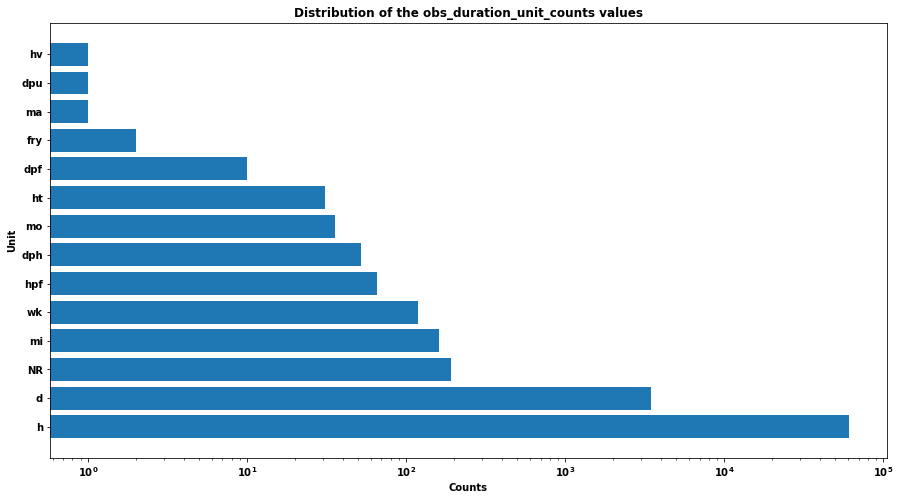

In [172]:
plt.barh(obs_duration_unit_counts.index, obs_duration_unit_counts.values, log=True)
plt.title("Distribution of the obs_duration_unit_counts values")
plt.xlabel("Counts")
plt.ylabel("Unit");

**log scale**  
Looking into NR values

In [173]:
df_obs[df_obs.obs_duration_unit == "NR"].obs_duration_mean.value_counts(dropna=False)

NR    191
Name: obs_duration_mean, dtype: int64

They are **both NR**. We could **drop** them without problem and proceed  
Analyzing the durations mean to look at the missing values

In [183]:
obs_duration_means_count = df_obs.obs_duration_mean.value_counts(dropna=False)
indexs_nulls = ((obs_duration_means_count.index == "NR") | (obs_duration_means_count.index == "NC") | (obs_duration_means_count.index == "NaN"))
obs_duration_means_count[indexs_nulls]

NR    1201
Name: obs_duration_mean, dtype: int64

Only **NR**, for a total of 1201 values. Considering in which categories of unit these fall:

In [186]:
null_obs_on_unit = df_obs[df_obs.obs_duration_mean == "NR"].obs_duration_unit.value_counts(dropna=False)
null_obs_on_unit

h      864
NR     191
d       89
ht      29
mi      23
wk       3
fry      2
Name: obs_duration_unit, dtype: int64

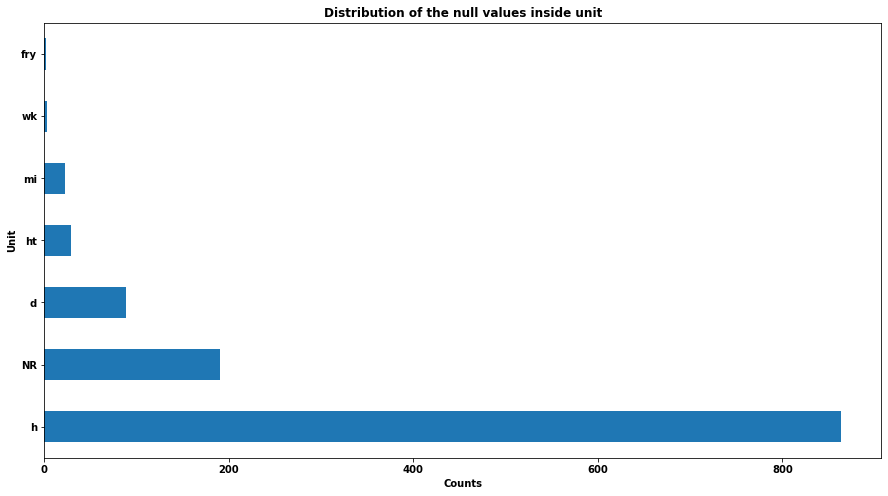

In [191]:
#plot of the distribution of null values across different units:
null_obs_on_unit.plot(kind="barh")
plt.title("Distribution of the null values inside unit")
plt.xlabel("Counts")
plt.ylabel("Unit");

The value with most nulls is hour (but it has a total of 60000 possible values inside). We could drop or impute them.  
**Simple imputing method: assign them the median/mean of the other values inside the same unit**
Next, plot of the distribution of units inside the hours/days groups

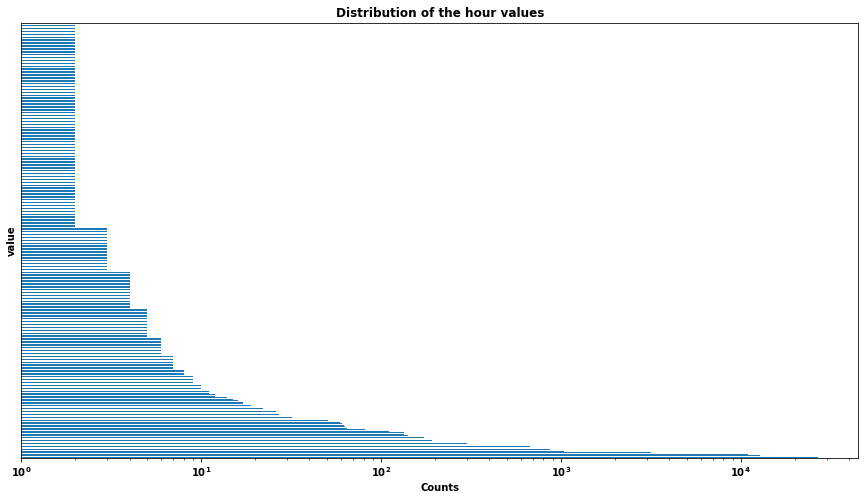

In [242]:
obs_means_h_count = df_obs[df_obs.obs_duration_unit=="h"].obs_duration_mean.value_counts(dropna=False)
obs_means_h_count.plot(kind="barh", log=True)
plt.yticks([]);
plt.title("Distribution of the hour values")
plt.xlabel("Counts")
plt.ylabel("value");

In [237]:
obs_means_h_count.index.size

285

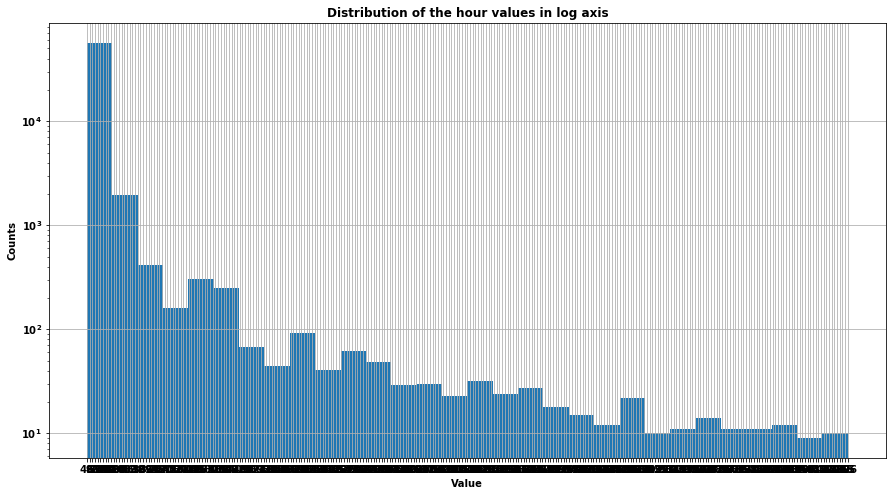

In [271]:
#histogram for better visualize
df_obs[df_obs.obs_duration_unit=="h"].obs_duration_mean.hist(bins=30)
plt.yscale("log")
plt.title("Distribution of the hour values in log axis")
plt.xlabel("Value")
plt.ylabel("Counts");

Power law, many experiments dure the same, other very rare
Impossible to visualize all the counts, printing the top

In [204]:
obs_means_h_count.head(15)

96     26981
24     12728
48     10909
72      3178
6       1046
NR       864
3        789
12       670
1        522
120      301
2        191
168      191
144      182
36       173
9        141
Name: obs_duration_mean, dtype: int64

Lot of variety seen, but the feature can be used for sure one imputed missing values

In [246]:
obs_means_d_count.index.size

94

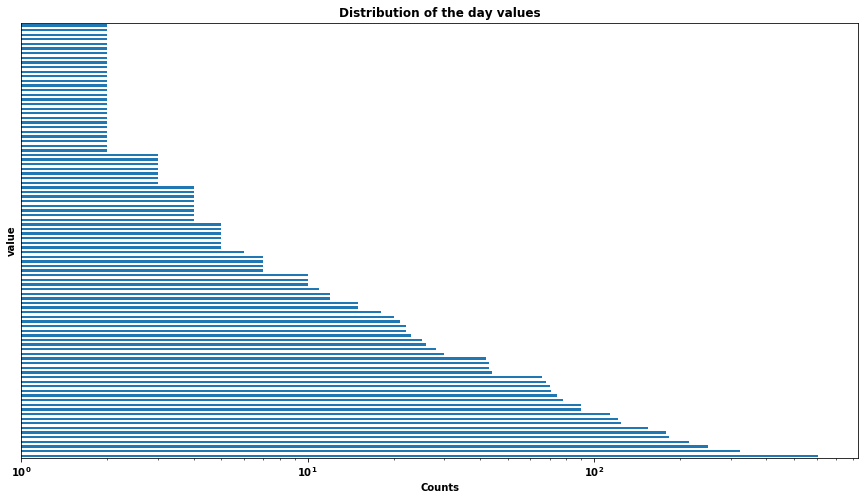

In [245]:
obs_means_d_count = df_obs[df_obs.obs_duration_unit=="d"].obs_duration_mean.value_counts(dropna=False)
obs_means_d_count.plot(kind="barh", log=True)
plt.yticks([]);
plt.title("Distribution of the day values")
plt.xlabel("Counts")
plt.ylabel("value");

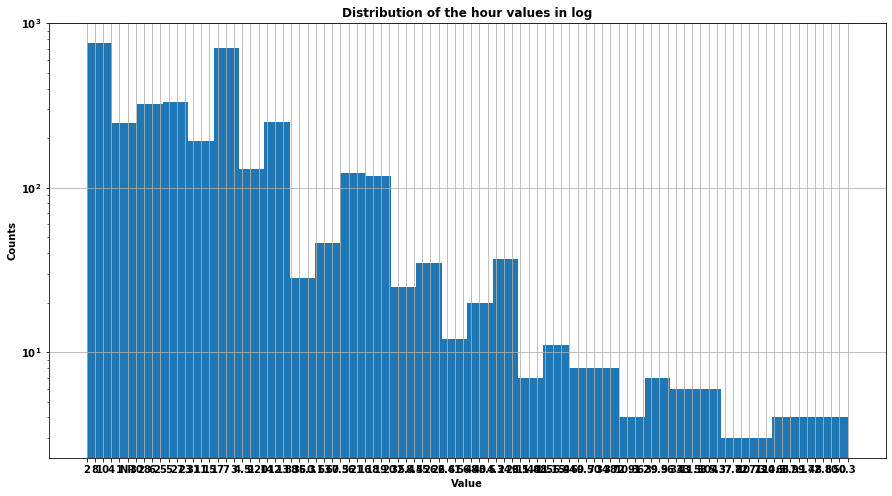

In [269]:
#obs_means_d_count.hist(bins=50)
df_obs[df_obs.obs_duration_unit=="d"].obs_duration_mean.hist(bins = 30)
plt.yscale("log")
plt.title("Distribution of the hour values in log")
plt.xlabel("Value")
plt.ylabel("Counts");
#plt.xticks([]);

The duration of the experiments assume the form of a power law. Most of the experiments have the same duration, with other very rare

In [206]:
obs_means_d_count.head(15)

7     606
4     323
5     250
8     213
10    181
28    177
14    153
11    123
6     120
9     113
NR     89
30     89
12     77
20     73
21     70
Name: obs_duration_mean, dtype: int64

Same as before.
#### Using this feature, after all the necessary imputation can be productive

### Study duration case

In [207]:
# Computing dataframe for study duration
df_study_dur_nan, study_dur_list = null_output_counts("study", results_final)
df_study_dur_nan

,null_values_inc_NC_NR%,#outputs
study_duration_mean_op,99.8177,5
study_duration_mean,91.2087,68
study_duration_min_op,99.9645,3
study_duration_min,99.9598,5
study_duration_max_op,99.9645,3
study_duration_max,99.9598,5
study_duration_unit,91.167,9
study_duration_comments,99.9521,3
study_type,99.9444,9
study_type_comments,100,1


**No need of further analysis. Too much NaNs to decide to proceed**

### CONCENTRATIONS

In [542]:
# Computing dataframe for concentrations
df_conc_nan, conc_list = null_output_counts("conc", results_final)
df_conc_nan

,null_values_inc_NC_NR%,#outputs
conc1_type,2.68279,8
conc1_mean_op,90.6774,6
conc1_mean,3.99716,9606
conc1_min_op,97.1458,5
conc1_min,48.7459,7407
conc1_max_op,97.1411,5
conc1_max,48.7474,8273
conc1_unit,0.00926698,66
conc1_comments,93.3309,164
conc2_type,98.4802,5


In [544]:
df_conc_nan[df_conc_nan['null_values_inc_NC_NR%']<65]

,null_values_inc_NC_NR%,#outputs
conc1_type,2.68279,8
conc1_mean,3.99716,9606
conc1_min,48.7459,7407
conc1_max,48.7474,8273
conc1_unit,0.00926698,66


Only **conc1 seems useful**:

In [13]:
# Computing dataframe for concentration 1
df_conc_nan, conc_list = null_output_counts("conc1", results_final)
df_conc_nan[df_conc_nan['null_values_inc_NC_NR%']<65]

,null_values_inc_NC_NR%,#outputs
conc1_type,2.68279,8
conc1_mean,3.99716,9606
conc1_min,48.7459,7407
conc1_max,48.7474,8273
conc1_unit,0.00926698,66


As usual, considering the **mean and unit**. Useful to look also to type:

In [14]:
conc_intrs = ['conc1_type', 'conc1_mean', 'conc1_unit']
df_conc = results_final[conc_intrs]

In [25]:
df_conc1type_unit_counts = df_conc.conc1_type.value_counts(dropna=False)

In [26]:
df_conc1type_unit_counts

A     29021
F     16787
T     15367
NC     1733
D      1113
U       686
L        35
NR        4
Name: conc1_type, dtype: int64

**Small number of NaN, few categories: could be useful as categorical**
Definitions:
- A: Active ingredients
- F: Formulation
- D: Dissolved
- L: Labile
- T: Total
- U: Unionized

C:\Users\Manuel\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  """Entry point for launching an IPython kernel.


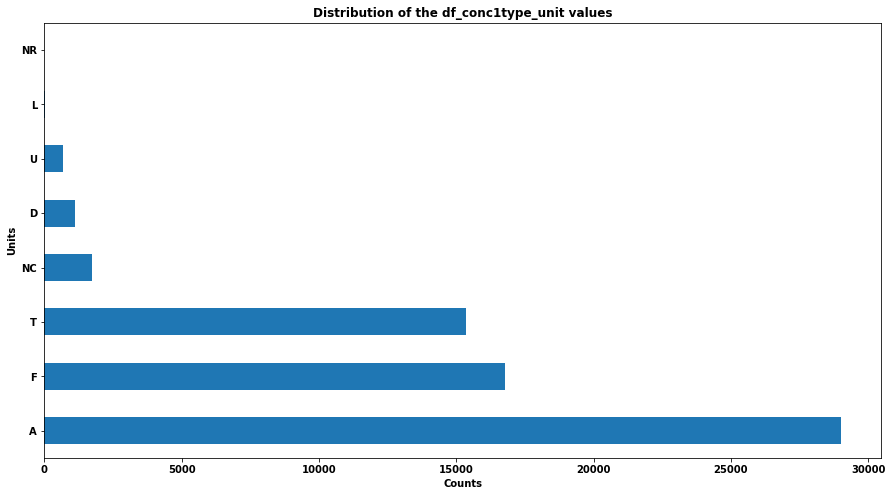

In [17]:
df_conc1type_unit_counts.plot('barh')
plt.title("Distribution of the df_conc1type_unit values")
plt.xlabel("Counts")
plt.ylabel("Units");

It's fine, we can keep this info. It's also good because there a few null.

Considering now units:

In [18]:
conc_unit_counts = df_conc.conc1_unit.value_counts(dropna=False)
conc_unit_counts.head(10)

ug/L       38915
mg/L        8548
ppm         5078
AI ug/L     4611
AI mg/L     2669
ppb         1445
ul/L        1159
uM           371
AI ng/L      234
AI ppb       228
Name: conc1_unit, dtype: int64

In [19]:
conc_unit_counts.size

66

**66 different concentrations**: how to deal with all these different units?  
**_AI_** is active ingredients -> What's the difference with the normal case?

As we see, there are a lot of different unit and all makes sense. More details in **data/DataCodes.pdf (Appendix N & W)**

A closer look :

C:\Users\Manuel\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  """Entry point for launching an IPython kernel.


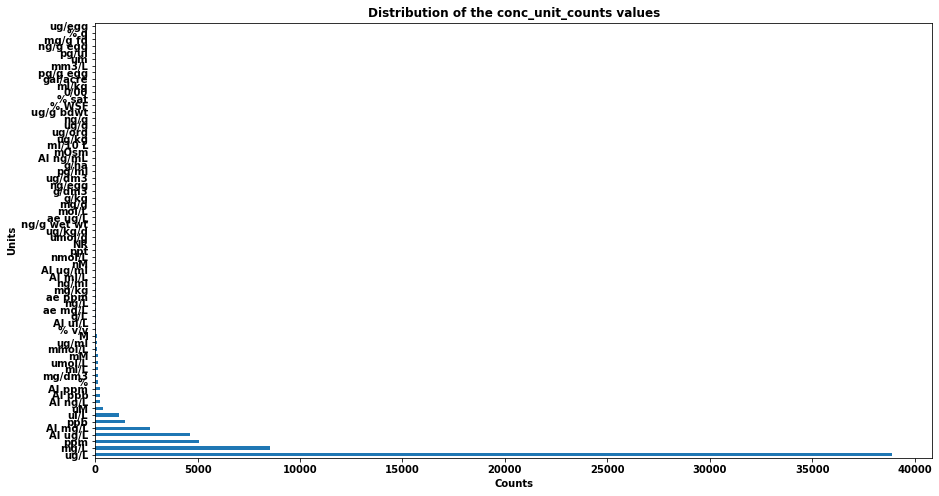

In [20]:
conc_unit_counts.plot('barh')
plt.title("Distribution of the conc_unit_counts values")
plt.xlabel("Counts")
plt.ylabel("Units");

In [21]:
conc_unit_counts.head(10).sum()/conc_unit_counts.sum()

0.977017885274766

Only best 10 retained:

In [24]:
conc_unit_best = conc_unit_counts.head(10).index.values

**Concentration is a variable we need for sure**. We should fix it, proposed solutions are the same as for organisms:
- Considering a categorical definition
- All in the same units
- We consider only some units,for example the first 10

In [43]:
conc_unit_mean_counts = df_conc.conc1_mean.value_counts(dropna=False)
conc_unit_mean_counts.head(10)

NR         2588
100         633
10000       454
1000        391
1000000     345
10          300
100000      265
50          261
5000        219
200         209
Name: conc1_mean, dtype: int64

In [44]:
conc_unit_mean_counts.size

9606

In [53]:
max(conc_unit_mean_counts)

2588

We rember we have only the 4% of null values for this feature.
<br>
We have differnt out, maybe too many? We could divide them into classes?

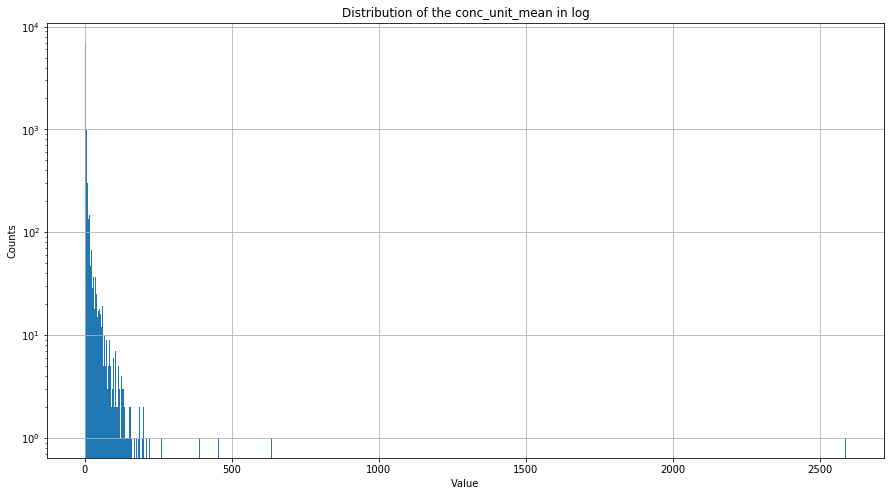

In [55]:
conc_unit_mean_counts.hist(bins = 1000)
plt.yscale("log")
plt.title("Distribution of the conc_unit_mean in log")
plt.xlabel("Value")
plt.ylabel("Counts");
#plt.xticks([]);

In [35]:
columns_final += ['conc1_type', 'conc1_mean', 'conc1_unit']

### PUBLICATION YEAR

In [272]:
df_pub_year_nan, pub_year_list = null_output_counts("publ", results_final)
df_pub_year_nan

,null_values_inc_NC_NR%,#outputs
published_date,47.6292,65


Half of the dates are missing  
Look at the distribution of publication years

In [273]:
published_dates = results_final["published_date"]

In [287]:
date_counts = published_dates.value_counts(dropna=False)
date_counts

NaN           30838
06/15/2012     7533
06/14/2013     3958
06/20/2000     1128
03/05/2008     1110
              ...  
06/11/2001       73
12/14/2017       51
03/16/2011       39
03/09/2015       36
03/26/2001       22
Name: published_date, Length: 65, dtype: int64

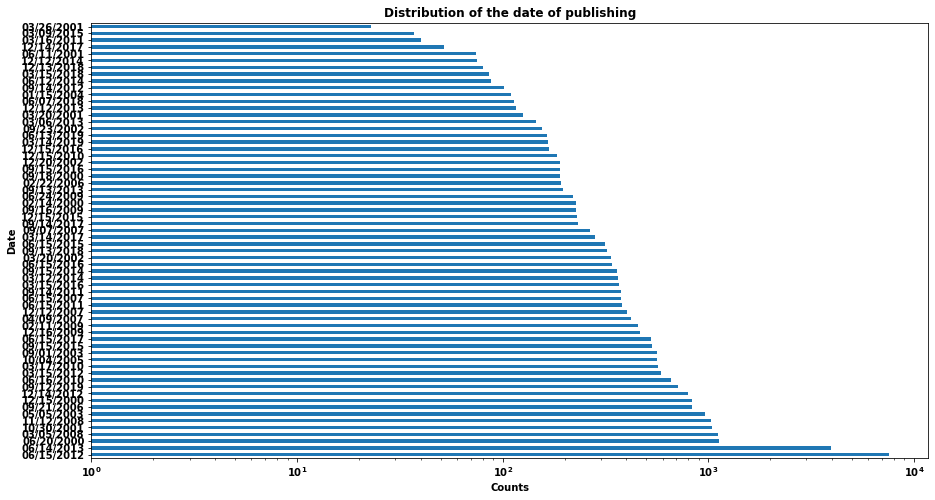

In [306]:
#drop na
date_counts = published_dates.value_counts()
date_counts.plot(kind="barh", log=True)
plt.title("Distribution of the date of publishing")
plt.xlabel("Counts")
plt.ylabel("Date");

We see that a lot of paper has been published on 15/06/2012. We can try to group by year and see when most of the paper has been published

In [299]:
date_counts.index = pd.to_datetime(date_counts.index)
date_grouped = date_counts.groupby(by=date_counts.index.year)
date_counts_years = date_grouped.agg(sum)
date_counts_years

2000    2375
2001    1256
2002     678
2003    1519
2004     109
2005     563
2006    1027
2007    1464
2008    2139
2009    1364
2010    1408
2011     795
2012    9016
2013    4413
2014     884
2015    1112
2016    1061
2017    1087
2018     599
2019    1039
Name: published_date, dtype: int64

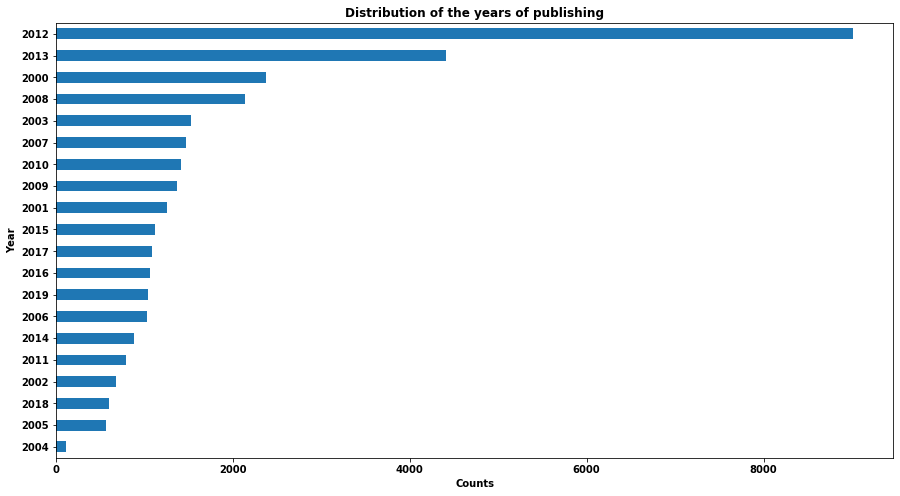

In [307]:
date_counts_years.sort_values().plot(kind="barh");
plt.title("Distribution of the years of publishing")
plt.xlabel("Counts")
plt.ylabel("Year");

**2012** is the most active year for our research, basically doubling the sequent year.

## Retaining final columns

In [36]:
columns_final

['organism_lifestage',
 'organism_characteristics',
 'exposure_type',
 'obs_duration_unit',
 'obs_duration_mean',
 'conc1_type',
 'conc1_mean',
 'conc1_unit']

Adding other useful columns

In [41]:
columns_final += ["test_cas"]

Species columns:

In [42]:
columns_final += ["class", "tax_order", "family", "genus", "species"]

In [43]:
columns_final += ["ecotox_group"]

Final df:

In [670]:
results_extr = results_final.copy()

In [671]:
results_extr = results_extr[columns_final]

In [672]:
columns_final

['organism_lifestage',
 'organism_characteristics',
 'exposure_type',
 'obs_duration_unit',
 'obs_duration_mean',
 'conc1_type',
 'conc1_mean',
 'conc1_unit',
 'test_cas',
 'class',
 'tax_order',
 'family',
 'genus',
 'species',
 'ecotox_group']

In [673]:
# Reordering
results_extr = results_extr[[
 'test_cas',
 'exposure_type',
 'obs_duration_unit',
 'obs_duration_mean',
 'conc1_type',
 'conc1_mean',
 'conc1_unit',
 'class',
 'tax_order',
 'family',
 'genus',
 'species',
 'organism_lifestage',
 'organism_characteristics',
 'ecotox_group']]

**Imputing**

First we take only the best 10 concentration unit as state before:

In [674]:
conc_unit_best

array(['ug/L', 'mg/L', 'ppm', 'AI ug/L', 'AI mg/L', 'ppb', 'ul/L', 'uM',
       'AI ng/L', 'AI ppb'], dtype=object)

In [675]:
results_extr = results_extr[results_extr.conc1_unit.isin(conc_unit_best)]

We remove AI and take a boolean for AI in another column:

In [676]:
results_extr.conc_AI = results_extr.conc1_unit.apply(lambda x: True if 'AI' in x else False)

C:\Users\Manuel\Anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [677]:
results_extr.conc1_unit = results_extr.conc1_unit.apply(lambda x: x.replace("AI ", "") if 'AI' in x else x)

In [678]:
results_extr.conc1_unit.value_counts(dropna=False)

ug/L    43526
mg/L    11217
ppm      5078
ppb      1673
ul/L     1159
uM        371
ng/L      234
Name: conc1_unit, dtype: int64

Before to do the conversion, we need to remove all the NaN, NC, NR values

In [679]:
count_conc_mean = results_extr.conc1_mean.value_counts(dropna=False)
count_conc_mean[count_conc_mean.index.isin(["NC", "NaN", "NR"])]

NR    2537
Name: conc1_mean, dtype: int64

Check in which unit value this NR appears:

In [680]:
results_extr[results_extr.conc1_mean=="NR"].conc1_unit.value_counts(dropna=False)

ug/L    1946
mg/L     465
ppm       92
ppb       16
ul/L      16
uM         2
Name: conc1_unit, dtype: int64

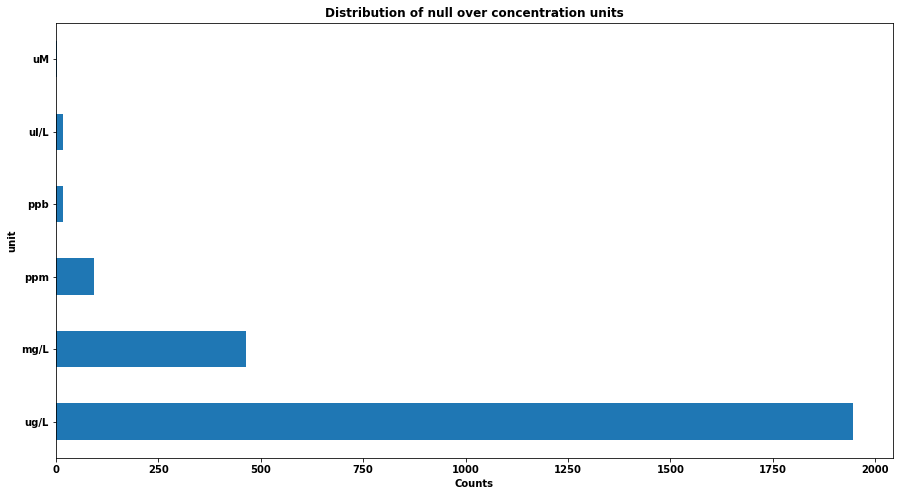

In [681]:
exposure_type_counts = results_extr[results_extr.conc1_mean=="NR"].conc1_unit.value_counts(dropna=False).plot(kind="barh")
plt.title("Distribution of null over concentration units")
plt.xlabel("Counts")
plt.ylabel("unit");

Equally distributed.  
Could be the case that this NR appear in conc2 (conc3 is all NaN). We check it

In [682]:
conc1_NR_index = results_extr[results_extr.conc1_mean =="NR"].index
list_conc = ["conc2_mean", "conc2_unit"]
other_conc = results_final[list_conc].copy()
other_conc = other_conc.loc[conc1_NR_index]
other_conc = other_conc.dropna()
other_conc[other_conc.conc2_mean!="NR"]

,conc2_mean,conc2_unit
2578,180.3,ug/L
13148,300,ug/L
16224,495.5,ug/L
50986,25657000,ug/L
56721,312.4,ug/L


We can impute 5 results using the value from conc2_mean

In [683]:
conc2_impute_index = other_conc[other_conc.conc2_mean!="NR"].index
results_extr.conc1_unit.loc[conc2_impute_index] = other_conc.conc2_unit.loc[conc2_impute_index]
results_extr.conc1_mean.loc[conc2_impute_index] = other_conc.conc2_mean.loc[conc2_impute_index]

C:\Users\Manuel\Anaconda3\envs\ml\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [684]:
count_conc_mean = results_extr.conc1_mean.value_counts(dropna=False)
count_conc_mean[count_conc_mean.index.isin(["NC", "NaN", "NR"])]

NR    2532
Name: conc1_mean, dtype: int64

For now we **drop them** all the remaining. Maybe in future we could find a way to impute them

In [685]:
drop_NR_mean = results_extr[results_extr.conc1_mean =="NR"].index
results_extr.drop(drop_NR_mean, inplace=True)

Finding strange values:

In [686]:
int_re = re.compile("[^.0-9]+")
matches_re = results_extr.conc1_mean.str.findall(int_re)
conc_tofix_mean = results_extr.conc1_mean[matches_re.str.len() > 0]
conc_tofix_mean

268         1000*
356           13*
374      4.14E+04
426          994*
547         6500*
           ...   
63618    2.41E+04
63935     270000*
63955       2154*
64488       1620*
64694        732*
Name: conc1_mean, Length: 503, dtype: object

We read in the documentation that a * means an experimental value, so we delete the *

In [687]:
results_extr.conc1_mean = results_extr.conc1_mean.apply(lambda x: x.replace("*", "") if "*" in x else x)

There's also a >100000. This doesn't means much to us, so we drop that

In [688]:
drop = results_extr[results_extr.conc1_mean ==">100000"].index
results_extr.drop(drop, inplace=True)

In [689]:
# Converting mean to number for next step
results_extr.conc1_mean = results_extr.conc1_mean.astype(float)

Now we convert all the possible to one unit of measure: **mg/L**
- 1 ug/L = $10^{-3}$ mg/L
- 1 ppb = 1 ug/L = $10^{-3}$ mg/L
- 1 ppm = 1 mg/L
- 1 ng/L = $10^{-6}$ mg/L

In [690]:
# Converting mg/L and ppm
results_extr.conc1_mean = np.where((results_extr['conc1_unit'] == "ug/L") | (results_extr['conc1_unit'] == "ppb"), \
                                   results_extr.conc1_mean/1000, results_extr.conc1_mean)

In [691]:
# Converting ng/L
results_extr.conc1_mean = np.where(results_extr['conc1_unit'] == "ng/L", \
                                   results_extr.conc1_mean*(10**(-6)), results_extr.conc1_mean)

Merging the new concentrations

In [692]:
results_extr.conc1_unit = results_extr.conc1_unit.apply(lambda x: "mg/L" if x in ["ug/L", "ppm", "ppb", "ng/L"] else x)

In [693]:
results_extr.conc1_unit.value_counts(dropna=False)

mg/L    59213
ul/L     1143
uM        369
Name: conc1_unit, dtype: int64

Check if we can recover the concentration value for ul/L or uM from conc2 or conc3

In [694]:
# search for possible imputings
concs_ind = results_extr[(results_extr.conc1_unit == "ul/L") | (results_extr.conc1_unit == "uM")].index
list_conc = ["conc2_mean", "conc2_unit"]
other_conc = results_final[list_conc].copy()
other_conc = other_conc.loc[concs_ind]
other_conc.dropna()

,conc2_mean,conc2_unit


No one value is in conc2, so we cannot impute them.

Now we can have three choices:
1. Categorize
2. Find a way to merge
3. Drop

For now we decide to **drop all the strange unit** (these rows are not a big deal for our purpose)

In [695]:
drop_concs = results_extr[results_extr.conc1_unit.str.contains("u")].index
results_extr.drop(drop_concs, inplace=True)

At this point we can drop the column

In [696]:
results_extr.drop(columns="conc1_unit", inplace=True)

Now consider the null

In [697]:
null_res,list_nulls = null_output_counts("", results_extr)
null_res.sort_values(by="null_values_inc_NC_NR%", ascending=False)

C:\Users\Manuel\Anaconda3\envs\ml\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,null_values_inc_NC_NR%,#outputs
organism_lifestage,66.0683,46
organism_characteristics,30.8311,6288
exposure_type,8.36641,16
conc1_type,2.92503,8
obs_duration_mean,0.868053,297
genus,0.405316,311
species,0.405316,497
obs_duration_unit,0.287099,13
family,0.121595,103
class,0.092885,4


### Exposure type

In [698]:
exposure_type_counts = results_extr.exposure_type.value_counts(dropna=False)
exposure_type_counts

S            35618
F            11704
R             6172
NR            4954
AQUA - NR      398
P              131
S/              70
R/              69
E               46
O               15
NR/             14
F/              12
P/               6
IP               2
FD               1
SP               1
Name: exposure_type, dtype: int64

As said before, all the NR become simply **AQUA**, also all the value with a / are merged with the normal representation

In [699]:
results_extr.exposure_type = results_extr.exposure_type.apply(lambda x: x.replace("/", ""))

In [700]:
exposure_type_counts = results_extr.exposure_type.value_counts(dropna=False)
exposure_type_counts

S            35688
F            11716
R             6241
NR            4968
AQUA - NR      398
P              137
E               46
O               15
IP               2
FD               1
SP               1
Name: exposure_type, dtype: int64

Now merging NR and AQUA - NR together

In [701]:
results_extr.exposure_type = results_extr.exposure_type.apply(lambda x: 'AQUA' if 'NR' in x else x)

Print of the final distribution

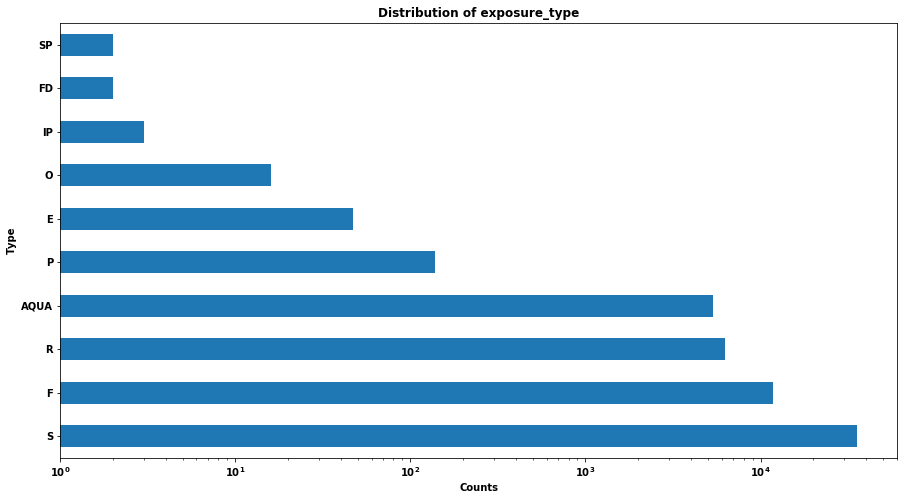

In [702]:
exposure_type_counts = results_extr.exposure_type.value_counts(dropna=False)
exposure_type_counts.plot(kind="barh", log=True)
plt.title("Distribution of exposure_type")
plt.xlabel("Counts")
plt.ylabel("Type");

Re-considering nulls

In [703]:
null_res,list_nulls = null_output_counts("", results_extr)
null_res.sort_values(by="null_values_inc_NC_NR%", ascending=False)

,null_values_inc_NC_NR%,#outputs
organism_lifestage,66.0683,46
organism_characteristics,30.8311,6288
conc1_type,2.92503,8
obs_duration_mean,0.868053,297
genus,0.405316,311
species,0.405316,497
obs_duration_unit,0.287099,13
family,0.121595,103
class,0.092885,4
tax_order,0.092885,29


### Conc1_type

In [704]:
results_extr.conc1_type.value_counts(dropna=False)

A     26609
F     15771
T     13550
NC     1728
D       858
U       665
L        28
NR        4
Name: conc1_type, dtype: int64

We can see is something useful emerge in conc2

In [705]:
type_ind = results_extr[(results_extr.conc1_type == "NC") | (results_extr.conc1_type == "NR")].index
other_conc = results_final["conc2_type"].copy()
other_conc = other_conc.loc[type_ind]
other_conc.dropna()

Series([], Name: conc2_type, dtype: object)

Nothing. We can only drop

In [706]:
drop_conc1_type = results_extr[(results_extr.conc1_type == "NC")|(results_extr.conc1_type == "NR")].index
results_extr.drop(drop_conc1_type, inplace=True)

### Observation duration (mean and units)

In [707]:
results_extr.obs_duration_unit.value_counts(dropna=False)

h      53909
d       3019
NR       170
mi       141
wk        92
hpf       48
dph       39
mo        36
ht        18
dpf        5
fry        2
hv         1
ma         1
Name: obs_duration_unit, dtype: int64

Dropping the 170 NR

In [708]:
drop_NR_dur_unit = results_extr[results_extr.obs_duration_unit =="NR"].index
results_extr.drop(drop_NR_dur_unit, inplace=True)

In [709]:
results_extr.obs_duration_unit.value_counts(dropna=False)

h      53909
d       3019
mi       141
wk        92
hpf       48
dph       39
mo        36
ht        18
dpf        5
fry        2
hv         1
ma         1
Name: obs_duration_unit, dtype: int64

Not considering the strange measures unit

In [710]:
good_obs_unit = ["h", "d", "mi", "wk", "mo"]
results_extr = results_extr[results_extr.obs_duration_unit.isin(good_obs_unit)]

In [711]:
results_extr.obs_duration_unit.value_counts(dropna=False)

h     53909
d      3019
mi      141
wk       92
mo       36
Name: obs_duration_unit, dtype: int64

In [712]:
count_obs_mean = results_extr.obs_duration_mean.value_counts(dropna=False)
count_obs_mean[count_obs_mean.index.isin(["NC", "NaN", "NR"])]

NR    324
Name: obs_duration_mean, dtype: int64

In [713]:
# Drop these rows
drop_NR_obs_mean = results_extr[results_extr.obs_duration_mean =="NR"].index
results_extr.drop(drop_NR_obs_mean, inplace=True)

In [714]:
results_extr.obs_duration_mean = results_extr.obs_duration_mean.astype(float)

Conversion:

All in **hours**:
- d -> d\*24
- mi -> mi/60
- wk -> wk\*7\*24
- mo -> mo\*30\*24

In [715]:
results_extr.obs_duration_mean = np.where(results_extr['obs_duration_mean'] == "d", \
                                   results_extr.obs_duration_mean*24, results_extr.obs_duration_mean)
results_extr.obs_duration_mean = np.where(results_extr['obs_duration_mean'] == "mi", \
                                   results_extr.obs_duration_mean/60, results_extr.obs_duration_mean)
results_extr.obs_duration_mean = np.where(results_extr['obs_duration_mean'] == "wk", \
                                   results_extr.obs_duration_mean*7*24, results_extr.obs_duration_mean)
results_extr.obs_duration_mean = np.where(results_extr['obs_duration_mean'] == "mo", \
                                   results_extr.obs_duration_mean*30*24, results_extr.obs_duration_mean)

In [716]:
# Drop no longer needed column unit
results_extr = results_extr.drop(columns="obs_duration_unit")

Plotting an histogram of the distribution of the new values:

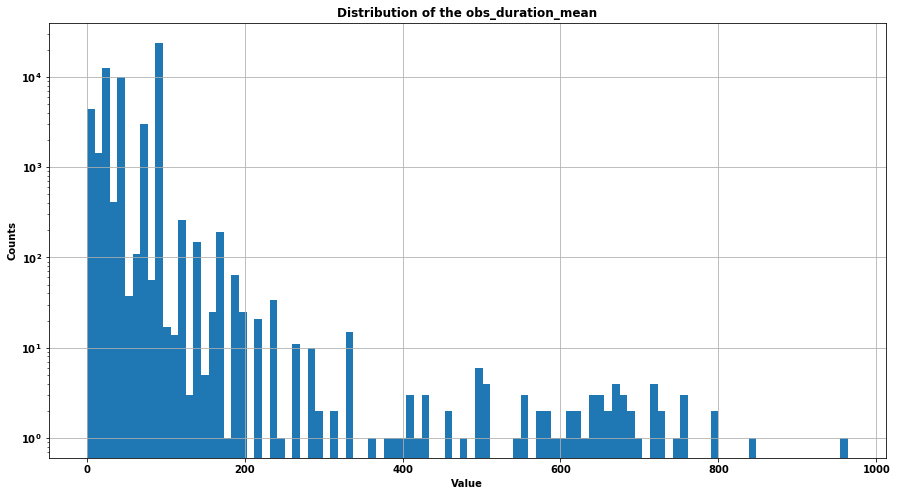

In [717]:
results_extr.obs_duration_mean.hist(bins=100)
plt.yscale("log")
plt.title("Distribution of the obs_duration_mean")
plt.xlabel("Value")
plt.ylabel("Counts");

The distribution is **skewed** (more than before thanks to the new added values too)

In [718]:
null_res,list_nulls = null_output_counts("", results_extr)
null_res.sort_values(by="null_values_inc_NC_NR%", ascending=False)

,null_values_inc_NC_NR%,#outputs
organism_lifestage,65.5759,46
organism_characteristics,31.7022,6047
genus,0.420235,310
species,0.420235,496
family,0.126598,103
class,0.0967067,4
tax_order,0.0967067,29
test_cas,0,3188
exposure_type,0,10
obs_duration_mean,0,272


#### Genus / Species

In [719]:
drop_genus = results_extr[results_extr.genus.isnull()].index
drop_species = results_extr[results_extr.species.isnull()].index

We observe that the null of genus and species are in the same position

In [720]:
list(drop_genus) == list(drop_species)

True

In [721]:
results_extr.drop(drop_genus, inplace=True)

In [722]:
null_res,list_nulls = null_output_counts("", results_extr)
null_res.sort_values(by="null_values_inc_NC_NR%", ascending=False)

,null_values_inc_NC_NR%,#outputs
organism_lifestage,65.5401,46
organism_characteristics,31.6806,6024
family,0.0070629,103
test_cas,0,3179
exposure_type,0,10
obs_duration_mean,0,272
conc1_type,0,6
conc1_mean,0,7818
class,0,3
tax_order,0,28


#### Family  
Only few nan values, directly dropped

In [723]:
drop_family = results_extr[results_extr.family.isnull()].index
results_extr.drop(drop_family, inplace=True)

In [724]:
null_res,list_nulls = null_output_counts("", results_extr)
null_res.sort_values(by="null_values_inc_NC_NR%", ascending=False)

,null_values_inc_NC_NR%,#outputs
organism_lifestage,65.5377,46
organism_characteristics,31.6829,6023
test_cas,0,3179
exposure_type,0,10
obs_duration_mean,0,272
conc1_type,0,6
conc1_mean,0,7815
class,0,3
tax_order,0,28
family,0,102


Check on concentration zeros:

In [725]:
results_extr[results_extr.conc1_mean == 0]

,test_cas,exposure_type,obs_duration_mean,conc1_type,conc1_mean,class,tax_order,family,genus,species,organism_lifestage,organism_characteristics,ecotox_group
51679,10108642,S,24.0,T,0.0,Actinopterygii,Pleuronectiformes,Scophthalmidae,Psetta,maxima,LV,"NEWLY HATCHED, YOLK SAC STAGE",Fish


In [726]:
results_extr[results_extr.obs_duration_mean == 0]

,test_cas,exposure_type,obs_duration_mean,conc1_type,conc1_mean,class,tax_order,family,genus,species,organism_lifestage,organism_characteristics,ecotox_group


In [727]:
drop = results_extr[results_extr.conc1_mean==0].index
results_extr.drop(drop, inplace=True)

In [728]:
print("Final dimension of the dataset: {}".format(results_extr.index.size))

Final dimension of the dataset: 56629


In [757]:
#results_extr.to_csv("output/base_db.csv")

In [36]:
base_db = pd.read_csv("output/base_db.csv").drop(columns="Unnamed: 0")

## CAS - SMILES 

In [8]:
smiles = pd.read_csv('data/cas_to_smiles.csv', error_bad_lines=False)

In [9]:
del smiles['Unnamed: 0']

In [10]:
smiles.head()

,cas,smiles
0,10108-64-2,[Cl-].[Cl-].[Cd++]
1,88-30-2,Oc1ccc(c(c1)C(F)(F)F)[N+]([O-])=O
2,1397-94-0,CCCCCC[C@@H]1[C@@H](OC(=O)CC(C)C)[C@H](C)OC(=O...
3,25474-41-3,NaN
4,540-72-7,[Na+].[S-]C#N


In [25]:
test = smiles[smiles['smiles'].isnull()].cas

In [26]:
test = test.apply(lambda x: x.replace("-", ""))

## Preprocessing on base_db

In [25]:
base_db = pd.read_csv('base_db_smiles.csv')

In [26]:
base_db.columns

Index(['Unnamed: 0', 'test_cas', 'exposure_type', 'obs_duration_mean',
       'conc1_type', 'conc1_mean', 'class', 'tax_order', 'family', 'genus',
       'species', 'organism_lifestage', 'organism_characteristics',
       'ecotox_group', 'smiles', 'atom_number', 'bonds_number', 'ring_numer',
       'Mol', 'MorganDensity', 'LogP'],
      dtype='object')

In [27]:
use_db = base_db.copy()
use_db = use_db[['test_cas', 'exposure_type', 'obs_duration_mean', 'conc1_type',
       'conc1_mean', 'class', 'tax_order', 'family', 'genus', 'species','atom_number', 'bonds_number', 'ring_numer',
       'Mol', 'MorganDensity', 'LogP']]

In [28]:
use_db.describe()

,obs_duration_mean,conc1_mean,atom_number,bonds_number,ring_numer,Mol,MorganDensity,LogP
count,53180.000000,5.318000e+04,53180.000000,53180.000000,53180.000000,53180.000000,53180.000000,53180.000000
mean,62.448187,3.457718e+02,13.589921,13.224878,1.097499,244.474903,1.071260,1.278474
std,41.799142,6.721350e+03,9.188111,10.412063,1.358434,132.967880,0.323409,3.678951
min,0.125000,5.200000e-08,1.000000,0.000000,0.000000,9.012000,0.200000,-24.338100
25%,24.000000,1.790000e-01,6.000000,4.000000,0.000000,159.609000,0.842105,-0.784780
50%,48.000000,2.200000e+00,13.000000,13.000000,1.000000,228.679000,1.111111,2.121800
75%,96.000000,2.230000e+01,19.000000,19.000000,2.000000,326.437000,1.272727,3.689800
max,964.000000,9.860000e+05,123.000000,135.000000,14.000000,1736.185000,2.000000,13.789100


### obs_duration_mean/conc1_mean

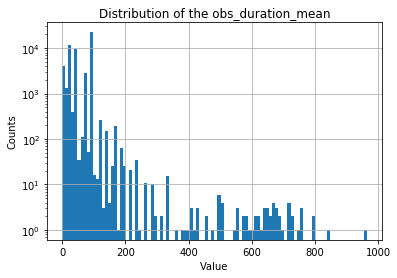

In [29]:
# plotted as before
use_db.obs_duration_mean.hist(bins=100)
plt.yscale("log")
plt.title("Distribution of the obs_duration_mean")
plt.xlabel("Value")
plt.ylabel("Counts");

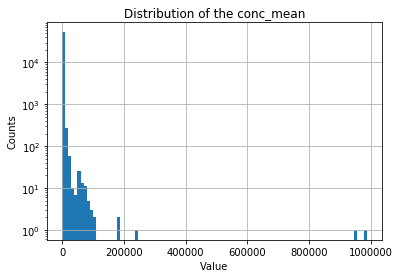

In [30]:
# plotted as before
use_db.conc1_mean.hist(bins=100)
plt.yscale("log")
plt.title("Distribution of the conc_mean")
plt.xlabel("Value")
plt.ylabel("Counts");

In [31]:
# logarithmic transformations
use_db.obs_duration_mean = use_db.obs_duration_mean.apply(lambda x: np.log1p(x))
#use_db.conc1_mean = use_db.conc1_mean.apply(lambda x: np.log1p(x)) #Not good result

In [32]:
# MinMax scale
minmax = MinMaxScaler()
minmax.fit(use_db[["obs_duration_mean"]])
use_db[["obs_duration_mean"]] = minmax.transform(use_db[["obs_duration_mean"]])

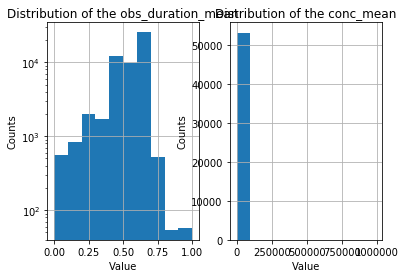

In [33]:
plt.subplot(1,2,1)
use_db.obs_duration_mean.hist(bins=10)
plt.title("Distribution of the obs_duration_mean")
plt.xlabel("Value")
plt.ylabel("Counts")
plt.yscale("log")
plt.subplot(1,2,2)
use_db.conc1_mean.hist(bins=10)
plt.title("Distribution of the conc_mean")
plt.xlabel("Value")
plt.ylabel("Counts");

In [35]:
use_db.describe()

,obs_duration_mean,conc1_mean,atom_number,bonds_number,ring_numer,Mol,MorganDensity,LogP
count,53180.000000,5.318000e+04,53180.000000,53180.000000,53180.000000,53180.000000,53180.000000,53180.000000
mean,0.555602,3.457718e+02,13.589921,13.224878,1.097499,244.474903,1.071260,1.278474
std,0.130311,6.721350e+03,9.188111,10.412063,1.358434,132.967880,0.323409,3.678951
min,0.000000,5.200000e-08,1.000000,0.000000,0.000000,9.012000,0.200000,-24.338100
25%,0.459126,1.790000e-01,6.000000,4.000000,0.000000,159.609000,0.842105,-0.784780
50%,0.558757,2.200000e+00,13.000000,13.000000,1.000000,228.679000,1.111111,2.121800
75%,0.659861,2.230000e+01,19.000000,19.000000,2.000000,326.437000,1.272727,3.689800
max,1.000000,9.860000e+05,123.000000,135.000000,14.000000,1736.185000,2.000000,13.789100


In [36]:
# standardization
scaler = StandardScaler()
scaler.fit(use_db[["obs_duration_mean"]])
use_db[["obs_duration_mean"]] = scaler.transform(use_db[["obs_duration_mean"]])

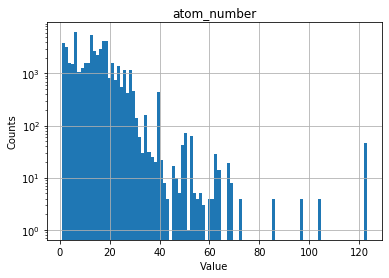

In [45]:
# plotted as before
use_db.atom_number.hist(bins=100)
plt.yscale("log")
plt.title("atom_number")
plt.xlabel("Value")
plt.ylabel("Counts");

In [58]:
# logarithmic transformations
use_db.atom_number = use_db.atom_number.apply(lambda x: np.log1p(x))
# MinMax scale
minmax = MinMaxScaler()
minmax.fit(use_db[["atom_number"]])
use_db[["atom_number"]] = minmax.transform(use_db[["atom_number"]])

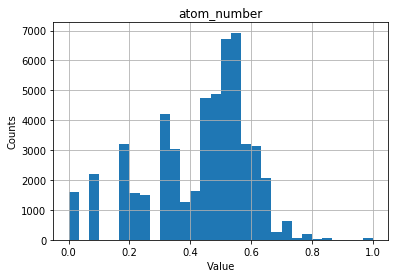

In [62]:
# plotted as before
use_db.atom_number.hist(bins=30)
plt.title("atom_number")
plt.xlabel("Value")
plt.ylabel("Counts");

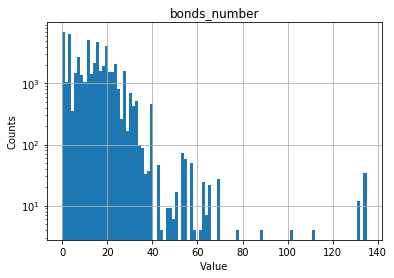

In [46]:
# plotted as before
use_db.bonds_number.hist(bins=100)
plt.yscale("log")
plt.title("bonds_number")
plt.xlabel("Value")
plt.ylabel("Counts");

In [63]:
# logarithmic transformations
use_db.bonds_number = use_db.bonds_number.apply(lambda x: np.log1p(x))
# MinMax scale
minmax = MinMaxScaler()
minmax.fit(use_db[["bonds_number"]])
use_db[["bonds_number"]] = minmax.transform(use_db[["bonds_number"]])

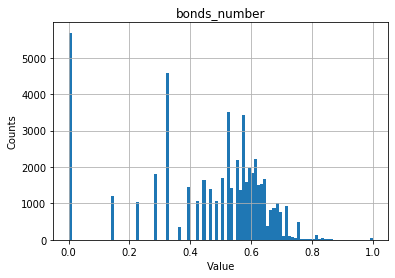

In [64]:
use_db.bonds_number.hist(bins=100)
plt.title("bonds_number")
plt.xlabel("Value")
plt.ylabel("Counts");

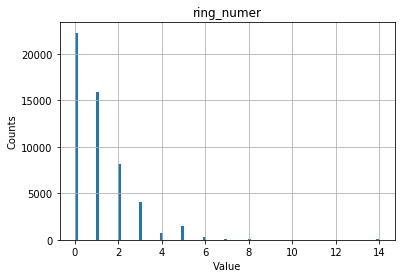

In [65]:
# plotted as before
use_db.ring_numer.hist(bins=100)
#plt.yscale("log")
plt.title("ring_numer")
plt.xlabel("Value")
plt.ylabel("Counts");

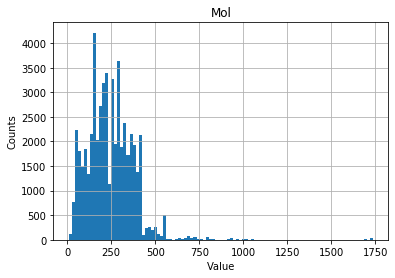

In [55]:
# plotted as before
use_db.Mol.hist(bins=100)
#plt.yscale("log")
plt.title("Mol")
plt.xlabel("Value")
plt.ylabel("Counts");

In [66]:
# MinMax scale
minmax = MinMaxScaler()
minmax.fit(use_db[["Mol"]])
use_db[["Mol"]] = minmax.transform(use_db[["Mol"]])

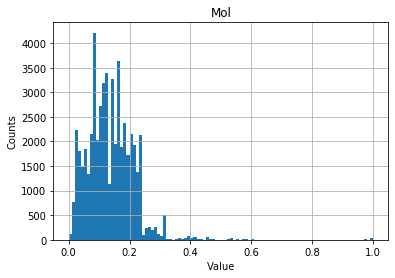

In [67]:
# plotted as before
use_db.Mol.hist(bins=100)
plt.title("Mol")
plt.xlabel("Value")
plt.ylabel("Counts");

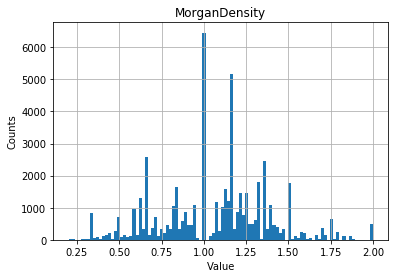

In [56]:
# plotted as before
use_db.MorganDensity.hist(bins=100)
#plt.yscale("log")
plt.title("MorganDensity")
plt.xlabel("Value")
plt.ylabel("Counts");

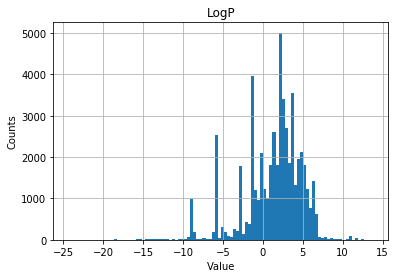

In [57]:
# plotted as before
use_db.LogP.hist(bins=100)
#plt.yscale("log")
plt.title("LogP")
plt.xlabel("Value")
plt.ylabel("Counts");

### For the concentration, no preprocessing considering this will be used as label for the regression case. Logarithmic transformation doesn't seem effective, scaling could be better

### categorical features  
We will need to encode exposure_type, conc1_type, class, tax_order, family_genus, species. Not done now because we will encoding depending on the case

In [55]:
# Category encoding
#use_db = pd.get_dummies(use_db)

### Simple classification 
Considering a threshold of 1mg/L of mortality

In [71]:
X = use_db.copy()
X = X[[
 'test_cas',
 'exposure_type',
 'obs_duration_mean',
 'conc1_type',
 'species', 
 'genus']]
X = pd.get_dummies(X)

In [155]:
y = base_db[["conc1_mean"]].copy().values
y = np.where(y > 1, 1, 0)

In [172]:
print(len(y[y==0]), len(y[y==1]))

23412 33217


In [157]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42)

In [177]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train.ravel())
y_pred = neigh.predict(X_test)

In [178]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8902504280821918

In [179]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100)
forest.fit(X_train, y_train.ravel())
y_pred = forest.predict(X_test)

In [180]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8326733732876712

In [187]:
from sklearn.ensemble import GradientBoostingClassifier
grboost = GradientBoostingClassifier()
grboost.fit(X_train, y_train.ravel())
y_pred = grboost.predict(X_test)

In [188]:
accuracy_score(y_test, y_pred)

0.7498929794520548

In [193]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(neigh, param_grid={"n_neighbors": list(range(1, 15))}, scoring="accuracy", cv=8)
grid.fit(X_train, y_train.ravel())

GridSearchCV(cv=8, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [199]:
grid.best_score_

0.9028228038269945

In [200]:
y_pred = grid.predict(X_test)

In [201]:
accuracy_score(y_test, y_pred)

0.9041630993150684

### Simple classification with Smile Features
Considering a threshold of 1mg/L of mortality

In [92]:
X = use_db.copy()
X = X[[
 'exposure_type',
 'obs_duration_mean',
 'conc1_type',
 'species',
 'atom_number',
 'bonds_number',
  'ring_numer',
  'Mol', 
  'MorganDensity', 'LogP']]
#X = pd.get_dummies(X)

In [93]:
X['exposure_type'].unique()

array(['S', 'F', 'R', 'AQUA', 'P', 'IP', 'E', 'SP', 'O', 'FD'],
      dtype=object)

In [94]:
X['conc1_type'].unique()

array(['T', 'D', 'L', 'F', 'A', 'U'], dtype=object)

In [95]:
X['species'].unique()

array(['auratus', 'heteroclitus', 'mykiss', 'variegatus', 'niloticus',
       'japonica', 'confluentus', 'catla', 'furzeri', 'fonticola',
       'adspersus', 'kisutch', 'saxatilis', 'punctatus', 'promelas',
       'vivipara', 'albonubes', 'major', 'oregonensis', 'gariepinus',
       'idella', 'dolichognathus', 'carpio', 'calcarifer', 'rerio',
       'gorbuscha', 'latipes', 'fossilis', 'joyneri', 'danricus',
       'notopterus', 'maxima', 'transmontanus', 'punctata', 'dearborni',
       'rohita', 'macrochirus', 'sp.', 'nerka', 'fontinalis', 'trutta',
       'forsteri', 'affinis', 'peninsulae', 'tshawytscha', 'marmoratus',
       'menidia', 'aculeatus', 'limanda', 'barbatus', 'reticulata',
       'majalis', 'mossambicus', 'quinqueradiata', 'bairdi', 'commersoni',
       'elegans', 'paradoxus', 'schlegelii', 'arulius', 'barbata',
       'lucius', 'texanus', 'mrigala', 'testudineus', 'curema',
       'microstoma', 'labrax', 'floridae', 'crysoleucas', 'salmoides',
       'salar', 'cyanellus

In [96]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(dtype=int)
enc.fit(X[["exposure_type", "conc1_type","species"]])
X[["exposure_type", "conc1_type","species"]] = enc.transform(X[["exposure_type", "conc1_type","species"]]) + 1

In [97]:
X.head()

,exposure_type,obs_duration_mean,conc1_type,species,atom_number,bonds_number,ring_numer,Mol,MorganDensity,LogP
0,9,0.024211,5,40,0.167949,0.0,0,0.10092,0.666667,-5.9945
1,9,-0.740360,5,208,0.167949,0.0,0,0.10092,0.666667,-5.9945
2,3,0.800083,5,312,0.167949,0.0,0,0.10092,0.666667,-5.9945
3,9,0.800083,5,474,0.167949,0.0,0,0.10092,0.666667,-5.9945
4,3,3.037407,5,312,0.167949,0.0,0,0.10092,0.666667,-5.9945


In [98]:
y = base_db[["conc1_mean"]].copy().values
y = np.where(y > 1, 1, 0)

In [99]:
print(len(y[y==0]), len(y[y==1]))

22224 30956


In [105]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [106]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train.ravel())
y_pred = neigh.predict(X_test)

In [107]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8392022792022792

In [108]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100)
forest.fit(X_train, y_train.ravel())
y_pred = forest.predict(X_test)

In [109]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9135042735042735

In [112]:
from sklearn.ensemble import GradientBoostingClassifier
grboost = GradientBoostingClassifier()
grboost.fit(X_train, y_train.ravel())
y_pred = grboost.predict(X_test)

In [113]:
accuracy_score(y_test, y_pred)

0.8338461538461538

In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(forest, param_grid={"n_estimators": list(range(1, 500))}, scoring="accuracy", cv=5)
grid.fit(X_train, y_train.ravel())

## Matrix factorization

In [3]:
base_db = pd.read_csv('output/base_db.csv')

In [4]:
X_fact = base_db.copy()
X_fact = X_fact[["test_cas", "species", "conc1_mean", "obs_duration_mean"]]

In [5]:
# # MinMax scale conc/duration
# minmax = MinMaxScaler((0, 5))
# minmax.fit(X_fact[["conc1_mean", "obs_duration_mean"]])
# X_fact[["conc1_mean", "obs_duration_mean"]] = minmax.transform(X_fact[["conc1_mean", "obs_duration_mean"]])

In [6]:
X_fact["score"] = 1/(X_fact.conc1_mean*X_fact.obs_duration_mean)

In [7]:
X_fact = X_fact.groupby(by=["test_cas", "species"]).agg("median")

In [8]:
X_fact = X_fact.drop(columns=["conc1_mean", "obs_duration_mean"]).reset_index()

In [9]:
X_fact.score = X_fact.score.apply(lambda x: np.log1p(x))

In [10]:
# MinMax scale score
minmax = MinMaxScaler((1, 5))
minmax.fit(X_fact[["score"]])
X_fact[["score"]] = minmax.transform(X_fact[["score"]])

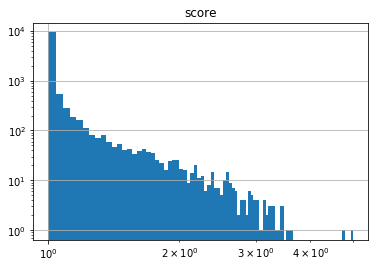

In [11]:
X_fact[["score"]].hist(bins=100)
plt.yscale("log")
plt.xscale("log")

In [12]:
X_fact.index.size

11650

In [13]:
X_fact[X_fact.score < 0.5].index.size

0

In [14]:
X_fact[X_fact.score > 4]

,test_cas,species,score
5139,1397940,spathula,4.783209
5869,2642719,niloticus,5.000000
8459,11118722,spathula,4.755218


In [15]:
t = X_fact.drop(index=[5139, 5869, 8459])

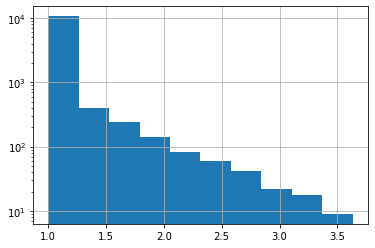

In [16]:
t.score.hist()
plt.yscale('log')

In [17]:
X_fact = t

In [18]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(dtype=int)
enc.fit(X_fact[["test_cas", "species"]])
X_fact[["test_cas", "species"]] = enc.transform(X_fact[["test_cas", "species"]]) + 1

In [19]:
X_fact["id"] = X_fact.test_cas.astype("str") + '_' + X_fact.species.astype("str")

In [20]:
X_fact = X_fact[["id", "score"]].set_index("id")
X_fact.to_csv("output/score_matrix.csv", header=True)

In [21]:
X_fact

,score
id,
1_6,1.000053
1_10,1.003552
1_40,1.000479
1_90,1.000107
1_104,1.000028
...,...
3175_394,1.000630
3176_394,1.000309
3177_395,1.273695


## Trying extra stuff from now on

In [22]:
X = use_db.copy()

NameError: name 'use_db' is not defined

In [23]:
X = X[[
 'test_cas',
 'exposure_type',
 'obs_duration_mean',
 'conc1_type',
 'species', 
 'genus']]

NameError: name 'X' is not defined

In [143]:
X = pd.get_dummies(X)

In [145]:
y = base_db[["conc1_mean"]].copy()

In [146]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42)

reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
reg.fit(X_train, y_train)

RidgeCV(alphas=array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [147]:
reg.alpha_

100.0

In [148]:
y_pred = reg.predict(X_test)

In [149]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

823622565.3658026

In [150]:
y_pred_train = reg.predict(X_train)
mean_squared_error(y_train, y_pred_train)

1131669125.734486

In [151]:
y_pred

array([[-5920.65118503],
       [ 2707.97196105],
       [11564.35121946],
       ...,
       [11542.53859393],
       [11395.38258818],
       [11795.73942915]])

In [152]:
y_test

,conc1_mean
16300,1.1300
14750,12.0000
51536,3.7000
46823,13.0000
38907,15.7000
...,...
49161,0.0005
56136,0.0150
30438,0.0007
170,0.2100
